<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/ml/combine_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


#### Download dataset

In [14]:
import kagglehub

path = kagglehub.dataset_download("abhisheksjha/time-series-air-quality-data-of-india-2010-2023")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'time-series-air-quality-data-of-india-2010-2023' dataset.
Path to dataset files: /kaggle/input/time-series-air-quality-data-of-india-2010-2023


In [15]:
path += "/AP001.csv"

In [16]:
aq_dataset = pd.read_csv(path, parse_dates=["From Date", "To Date"], index_col='From Date')

In [17]:
aq_dataset.head()

,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
From Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,2016-07-01 11:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.60,0.48,14.5,...,33.43,71.67,2.30,226.33,123.67,NaN,-0.1,0.1,0.0,23.05
2016-07-01 11:00:00,2016-07-01 12:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,15.0,...,33.70,70.00,2.50,223.00,186.00,NaN,-0.1,0.1,0.0,NaN
2016-07-01 12:00:00,2016-07-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 13:00:00,2016-07-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 14:00:00,2016-07-01 15:00:00,20.50,50.0,15.40,43.6,32.78,6.35,6.38,0.47,10.5,...,33.57,63.50,1.88,223.00,240.50,NaN,-0.1,0.1,0.0,NaN


In [18]:
aq_dataset.columns

Index(['To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)'],
      dtype='object')

<Axes: xlabel='From Date'>

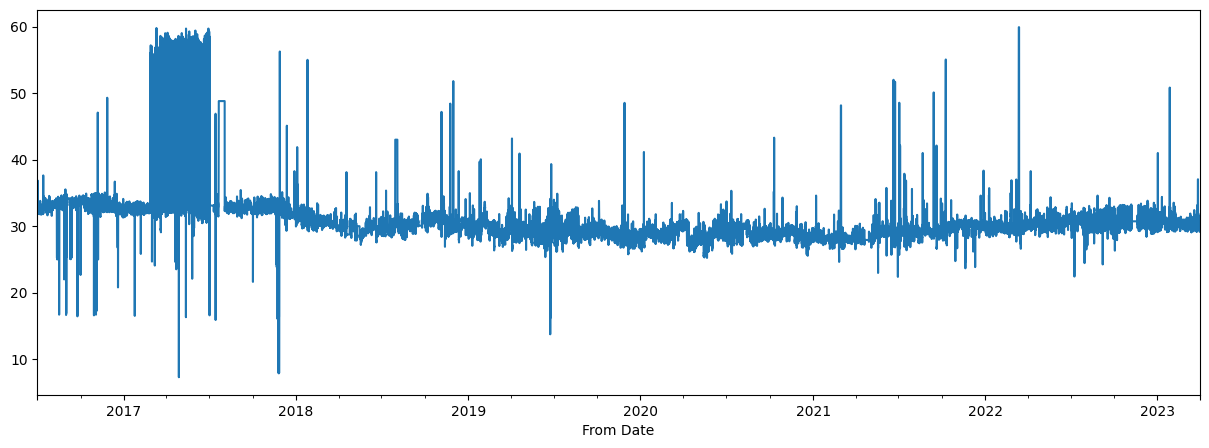

In [19]:
aq_dataset['Temp (degree C)'].ffill().plot(figsize=(15, 5))

##### Prepare features

In [20]:
ts = aq_dataset['Temp (degree C)'].ffill()
df = pd.DataFrame(ts)

for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df['Temp (degree C)'].shift(lag)

df['roll7_mean'] = df['Temp (degree C)'].rolling(7).mean().shift(1)
df['roll7_std'] = df['Temp (degree C)'].rolling(7).std().shift(1)

df = df.dropna()


In [21]:
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

X_train = train.drop(columns=['Temp (degree C)'])
y_train = train['Temp (degree C)']
X_test = test.drop(columns=['Temp (degree C)'])
y_test = test['Temp (degree C)']


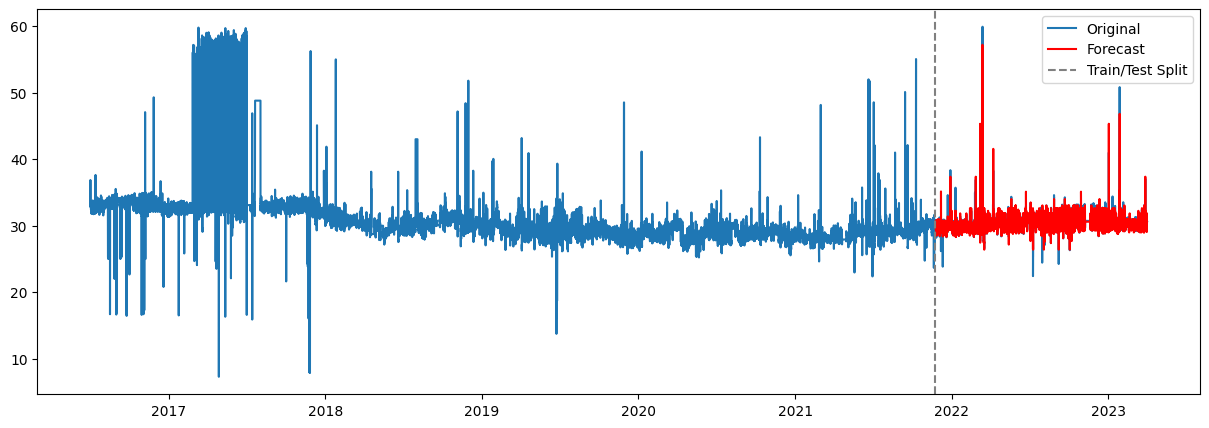

In [26]:
model = DecisionTreeRegressor(max_depth=9, random_state=42)
model.fit(X_train, y_train)

y_pred_decision_tree = model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, label='Original')
plt.plot(test.index, y_pred_decision_tree, label='Forecast', color='red')
plt.axvline(ts.index[split_idx], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


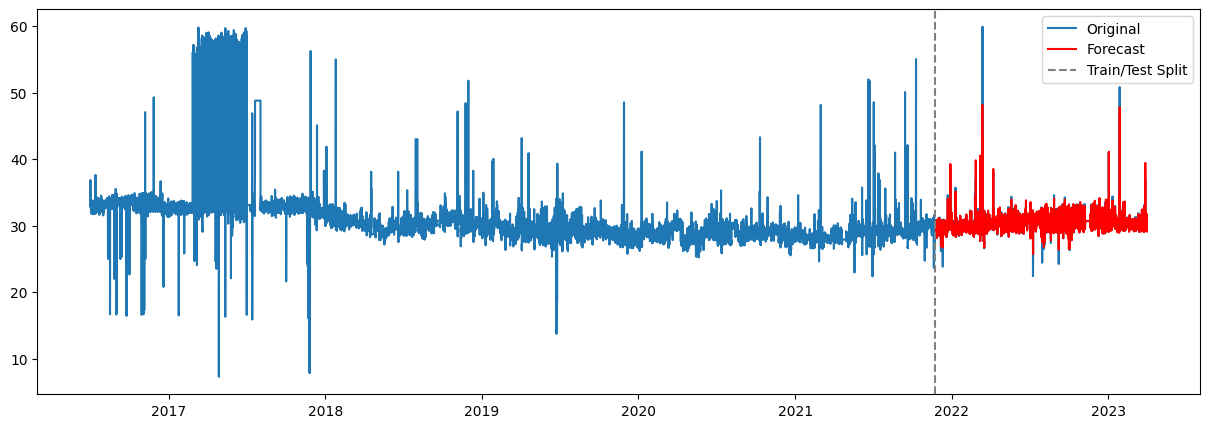

In [27]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, label='Original')
plt.plot(test.index, y_pred_rf, label='Forecast', color='red')
plt.axvline(ts.index[split_idx], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

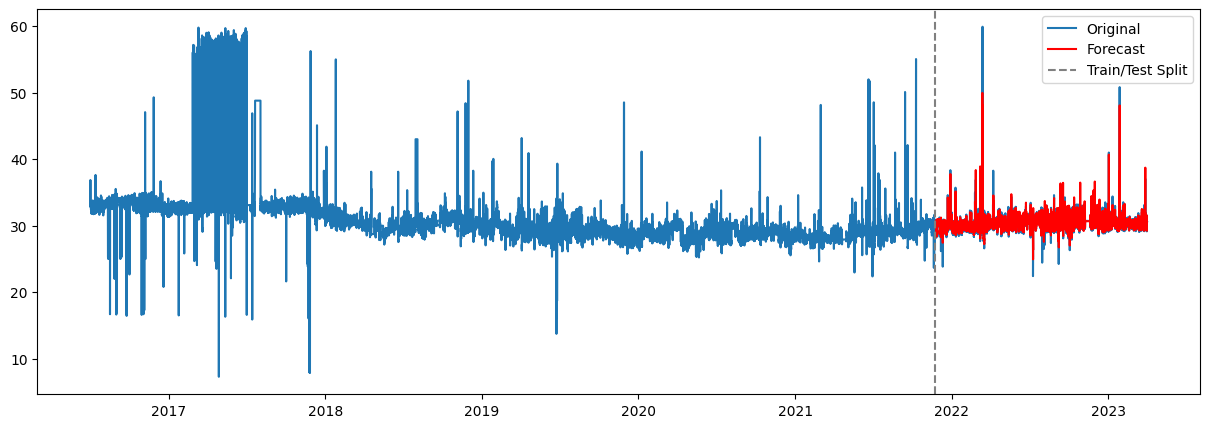

In [28]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, label='Original')
plt.plot(test.index, y_pred_xgb, label='Forecast', color='red')
plt.axvline(ts.index[split_idx], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

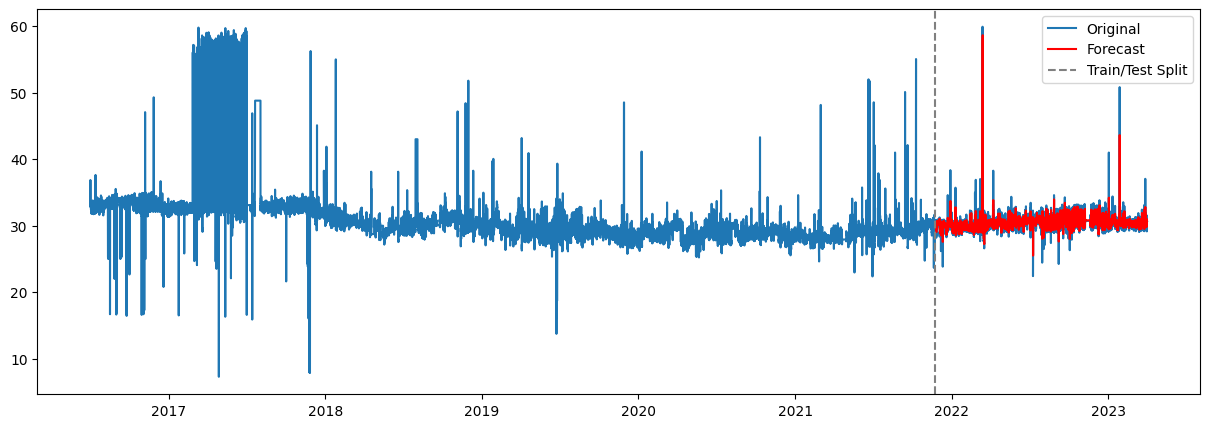

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast
y_pred_lr = model.predict(X_test)

# Plot original + forecast
plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, label='Original')
plt.plot(test.index, y_pred_lr, label='Forecast', color='red')
plt.axvline(ts.index[split_idx], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


In [32]:
preds = {
    'Linear Regression': y_pred_lr,
    'Decision Tree': y_pred_decision_tree,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

# Compute metrics for each model
metrics_list = []
rmse_values = []

for name, y_pred in preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    metrics_list.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    })

# --- Ensemble 1: Simple Average ---
y_pred_simple_avg = np.mean(
    np.column_stack([y_pred_lr, y_pred_decision_tree, y_pred_rf, y_pred_xgb]), axis=1
)
mae = mean_absolute_error(y_test, y_pred_simple_avg)
mse = mean_squared_error(y_test, y_pred_simple_avg)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred_simple_avg) / y_test)) * 100
r2 = r2_score(y_test, y_pred_simple_avg)
metrics_list.append({
    'Model': 'Ensemble (Simple Avg)',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE (%)': mape,
    'R²': r2
})

# --- Ensemble 2: Weighted Average (inverse RMSE weights) ---
rmse_array = np.array(rmse_values)
weights = 1 / rmse_array
weights /= weights.sum()  # normalize

y_pred_weighted_avg = (
    weights[0]*y_pred_lr + weights[1]*y_pred_decision_tree + weights[2]*y_pred_rf + weights[3]*y_pred_xgb
)
mae = mean_absolute_error(y_test, y_pred_weighted_avg)
mse = mean_squared_error(y_test, y_pred_weighted_avg)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred_weighted_avg) / y_test)) * 100
r2 = r2_score(y_test, y_pred_weighted_avg)
metrics_list.append({
    'Model': 'Ensemble (Weighted Avg)',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE (%)': mape,
    'R²': r2
})

# --- Create comparison table ---
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values(by='RMSE')
metrics_df.reset_index(drop=True, inplace=True)

print(metrics_df)


                     Model       MAE       MSE      RMSE  MAPE (%)        R²
0        Linear Regression  0.402839  0.614071  0.783627  1.298771  0.757616
1  Ensemble (Weighted Avg)  0.307048  0.697336  0.835067  0.959814  0.724750
2    Ensemble (Simple Avg)  0.303203  0.737811  0.858959  0.945128  0.708774
3            Random Forest  0.294217  0.943972  0.971582  0.905015  0.627398
4                  XGBoost  0.318164  1.081641  1.040020  0.981420  0.573058
5            Decision Tree  0.316462  1.138593  1.067049  0.980597  0.550578


Linear Regression performs very well here because the time series is mostly smooth with linear trends.

Random Forest and XGBoost may be overfitting on short-term variations; their RMSE is higher, but MAE is competitive.

Ensemble methods help combine strengths of linear (trend capturing) and trees (non-linear spikes). The weighted ensemble seems to balance well.